Step 1. Import library

In [1]:
import pandas as pd; pd.options.mode.chained_assignment = None
import numpy as np

# Built In Imports

from datetime import datetime
from glob import glob
from tqdm.notebook import tqdm

# Visualization Imports

from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from PIL import Image
import matplotlib
import plotly
import PIL
import cv2

from pycocotools.coco import COCO

# Other Imports

from tqdm.notebook import tqdm

LABEL_COLORS = [px.colors.label_rgb(px.colors.convert_to_RGB_255(x)) for x in sns.color_palette("Spectral", 10)]
LABEL_COLORS_WOUT_NO_FINDING = LABEL_COLORS[:8]+LABEL_COLORS[9:]

Step 2. Convert json to dataframe

In [2]:
coco = COCO('./../../dataset/train.json')
train_df = pd.DataFrame()
image_ids = []
class_name = []
class_id = []
x_min = []
y_min = []
x_max = []
y_max = []
classes = ["General trash", "Paper", "Paper pack", "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

for image_id in coco.getImgIds():
    imageinfo = coco.loadImgs(image_id)[0]
    annids = coco.getAnnIds(imgIds=imageinfo['id'])
    anns = coco.loadAnns(annids)
    filename = imageinfo['file_name']

    for ann in anns:
        image_ids.append(filename)
        class_name.append(classes[ann['category_id']])
        class_id.append(ann['category_id'])
        x_min.append(float(ann['bbox'][0]))
        y_min.append(float(ann['bbox'][1]))
        x_max.append(float(ann['bbox'][0]) + float(ann['bbox'][2]))
        y_max.append(float(ann['bbox'][1]) + float(ann['bbox'][3]))

train_df['image_id'] = image_ids
train_df['class_name'] = class_name
train_df['class_id'] = class_id
train_df['x_min'] = x_min
train_df['y_min'] = y_min
train_df['x_max'] = x_max
train_df['y_max'] = y_max

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


Step 3. EDA Annotation Per Images : 한 이미지에 몇 개의 Bounding box가 있는지, 그 분포를 나타낸 결과입니다.

In [3]:
fig = px.histogram(train_df.image_id.value_counts(), log_y=False, color_discrete_sequence=['indianred'], opacity=0.7,
                   labels={"value":"Number of Annotations Per Image"},
                   title="<b>DISTRIBUTION OF # OF ANNOTATIONS PER IMAGE "
                   "<i><sub>(Log Scale for Y-Axis)</sub></i></b>",)

fig.update_layout(showlegend=False,
                  xaxis_title="<b>이미지당 BBOX 개수</b>",
                  yaxis_title="<b>이미지 개수</b>",
                  width=800)

fig.show()

Unique Class Per Image

한 이미지의 몇 개의 unique한 class가 있는지, 그 분포를 나타낸 결과입니다.

In [4]:
fig = px.histogram(train_df.groupby('image_id')["class_id"].unique().apply(lambda x: len(x)),
                   log_y=False, color_discrete_sequence=['skyblue'], opacity=0.7,
                   labels={"value":"Number of Unique class"},
                   title="<b>DISTRIBUTION OF # OF Unique Class PER IMAGE " 
                   "<i><sub>(Log Scale for Y-Axis)</sub></i></b>",
                   )

fig.update_layout(showlegend=False,
                  xaxis_title="<b>Number of Unique CLASS</b>",
                  yaxis_title="<b>Count of Unique IMAGE</b>",
                  width=800)

fig.show()

Annotations Per Class

각 Class 당 몇 개의 Annotation, 즉 bbox가 있는지, 그 분포를 나타낸 결과입니다.

In [5]:
fig = px.bar(train_df.class_name.value_counts().sort_index(),
             color=train_df.class_name.value_counts().sort_index().index, opacity=0.85,
             color_discrete_sequence=LABEL_COLORS, log_y=False,
             labels={"y":"Annotations Per Class", "x":""},
             title="<b>Annotations Per Class</b>",)

fig.update_layout(legend_title=None,
                 xaxis_title="",
                 yaxis_title="<b>Annotations Per Class</b>",
                 width=800)

fig.show()

Object heatmap

이미지에서 bbox가 주로 어디에 위치하는지를 알아보기 위한 코드입니다.

  0%|          | 0/23144 [00:00<?, ?it/s]

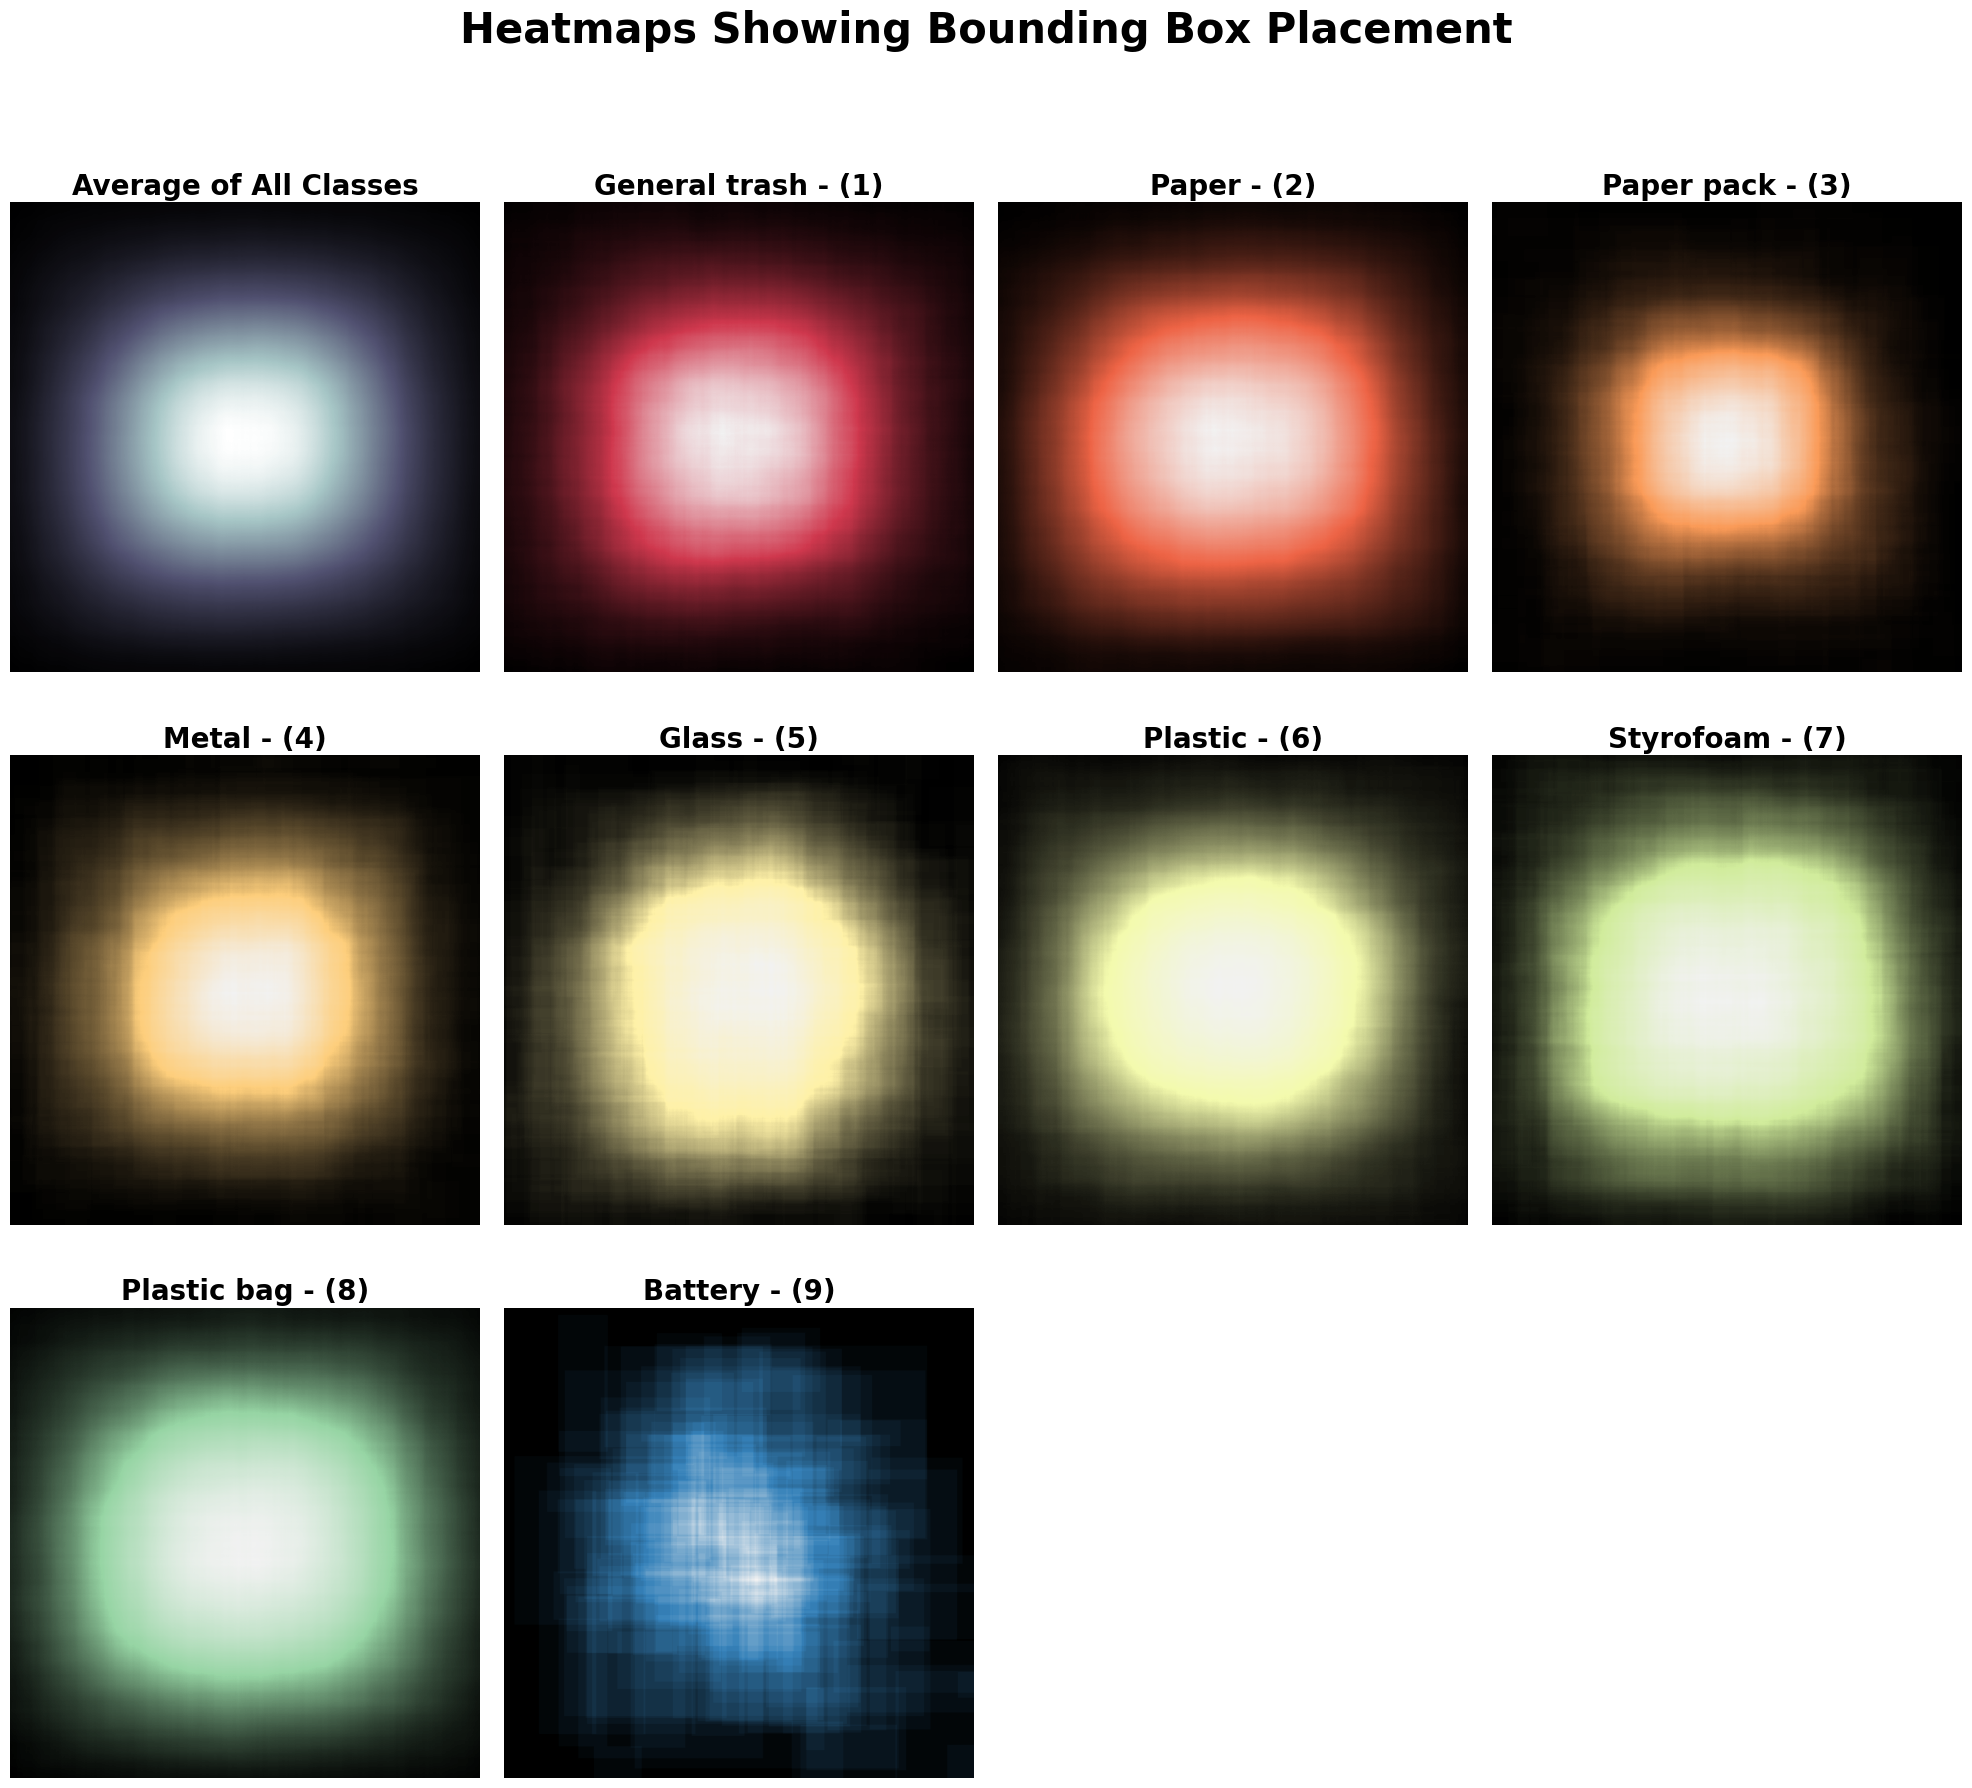

In [6]:
matplotlib.rcParams.update({'font.size': 16})
bbox_df = pd.DataFrame()
bbox_df['class_id'] = train_df['class_id'].values
bbox_df['class_name'] = train_df['class_name'].values
bbox_df['x_min'] = train_df['x_min'].values
bbox_df['x_max'] = train_df['x_max'].values
bbox_df['y_min'] = train_df['y_min'].values
bbox_df['y_max'] = train_df['y_max'].values
bbox_df['frac_x_min'] = train_df['x_min'].values / 1024
bbox_df['frac_x_max'] = train_df['x_max'].values / 1024
bbox_df['frac_y_min'] = train_df['y_min'].values / 1024
bbox_df['frac_y_max'] = train_df['y_max'].values / 1024
ave_src_img_height = 1024
ave_src_img_width = 1024

# DEFAULT

HEATMAP_SIZE = (ave_src_img_height, ave_src_img_width, 14)

# Initialize

heatmap = np.zeros((HEATMAP_SIZE), dtype=np.int16)
bbox_np = bbox_df[["class_id", "frac_x_min", "frac_x_max", "frac_y_min", "frac_y_max"]].to_numpy()
bbox_np[:, 1:3] *= ave_src_img_width
bbox_np[:, 3:5] *= ave_src_img_height
bbox_np = np.floor(bbox_np).astype(np.int16)

# Color map stuff

custom_cmaps = [
    matplotlib.colors.LinearSegmentedColormap.from_list(
        colors=[(0.,0.,0.), c, (0.95,0.95,0.95)],
        name=f"custom{i}") for i,c in enumerate(sns.color_palette("Spectral", 10))
    ]

custom_cmaps.pop(8) # Remove No-Finding

for row in tqdm(bbox_np, total=bbox_np.shape[0]): 
    heatmap[row[3]:row[4]+1, row[1]:row[2]+1, row[0]] += 1

fig = plt.figure(figsize=(20,25))
plt.suptitle("Heatmaps Showing Bounding Box Placement\n ", fontweight="bold", fontsize=30)

for i in range(10):
    plt.subplot(4, 4, i+1)
    if i==0:
        plt.imshow(heatmap.mean(axis=-1), cmap="bone")
        plt.title(f"Average of All Classes", fontweight="bold", fontsize=20)
        
    else:
        plt.imshow(heatmap[:, :, i-1], cmap=custom_cmaps[i-1])
        plt.title(f"{classes[i-1]} - ({i})", fontweight="bold", fontsize=20)

    plt.axis(False)

fig.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

  0%|          | 0/23144 [00:00<?, ?it/s]

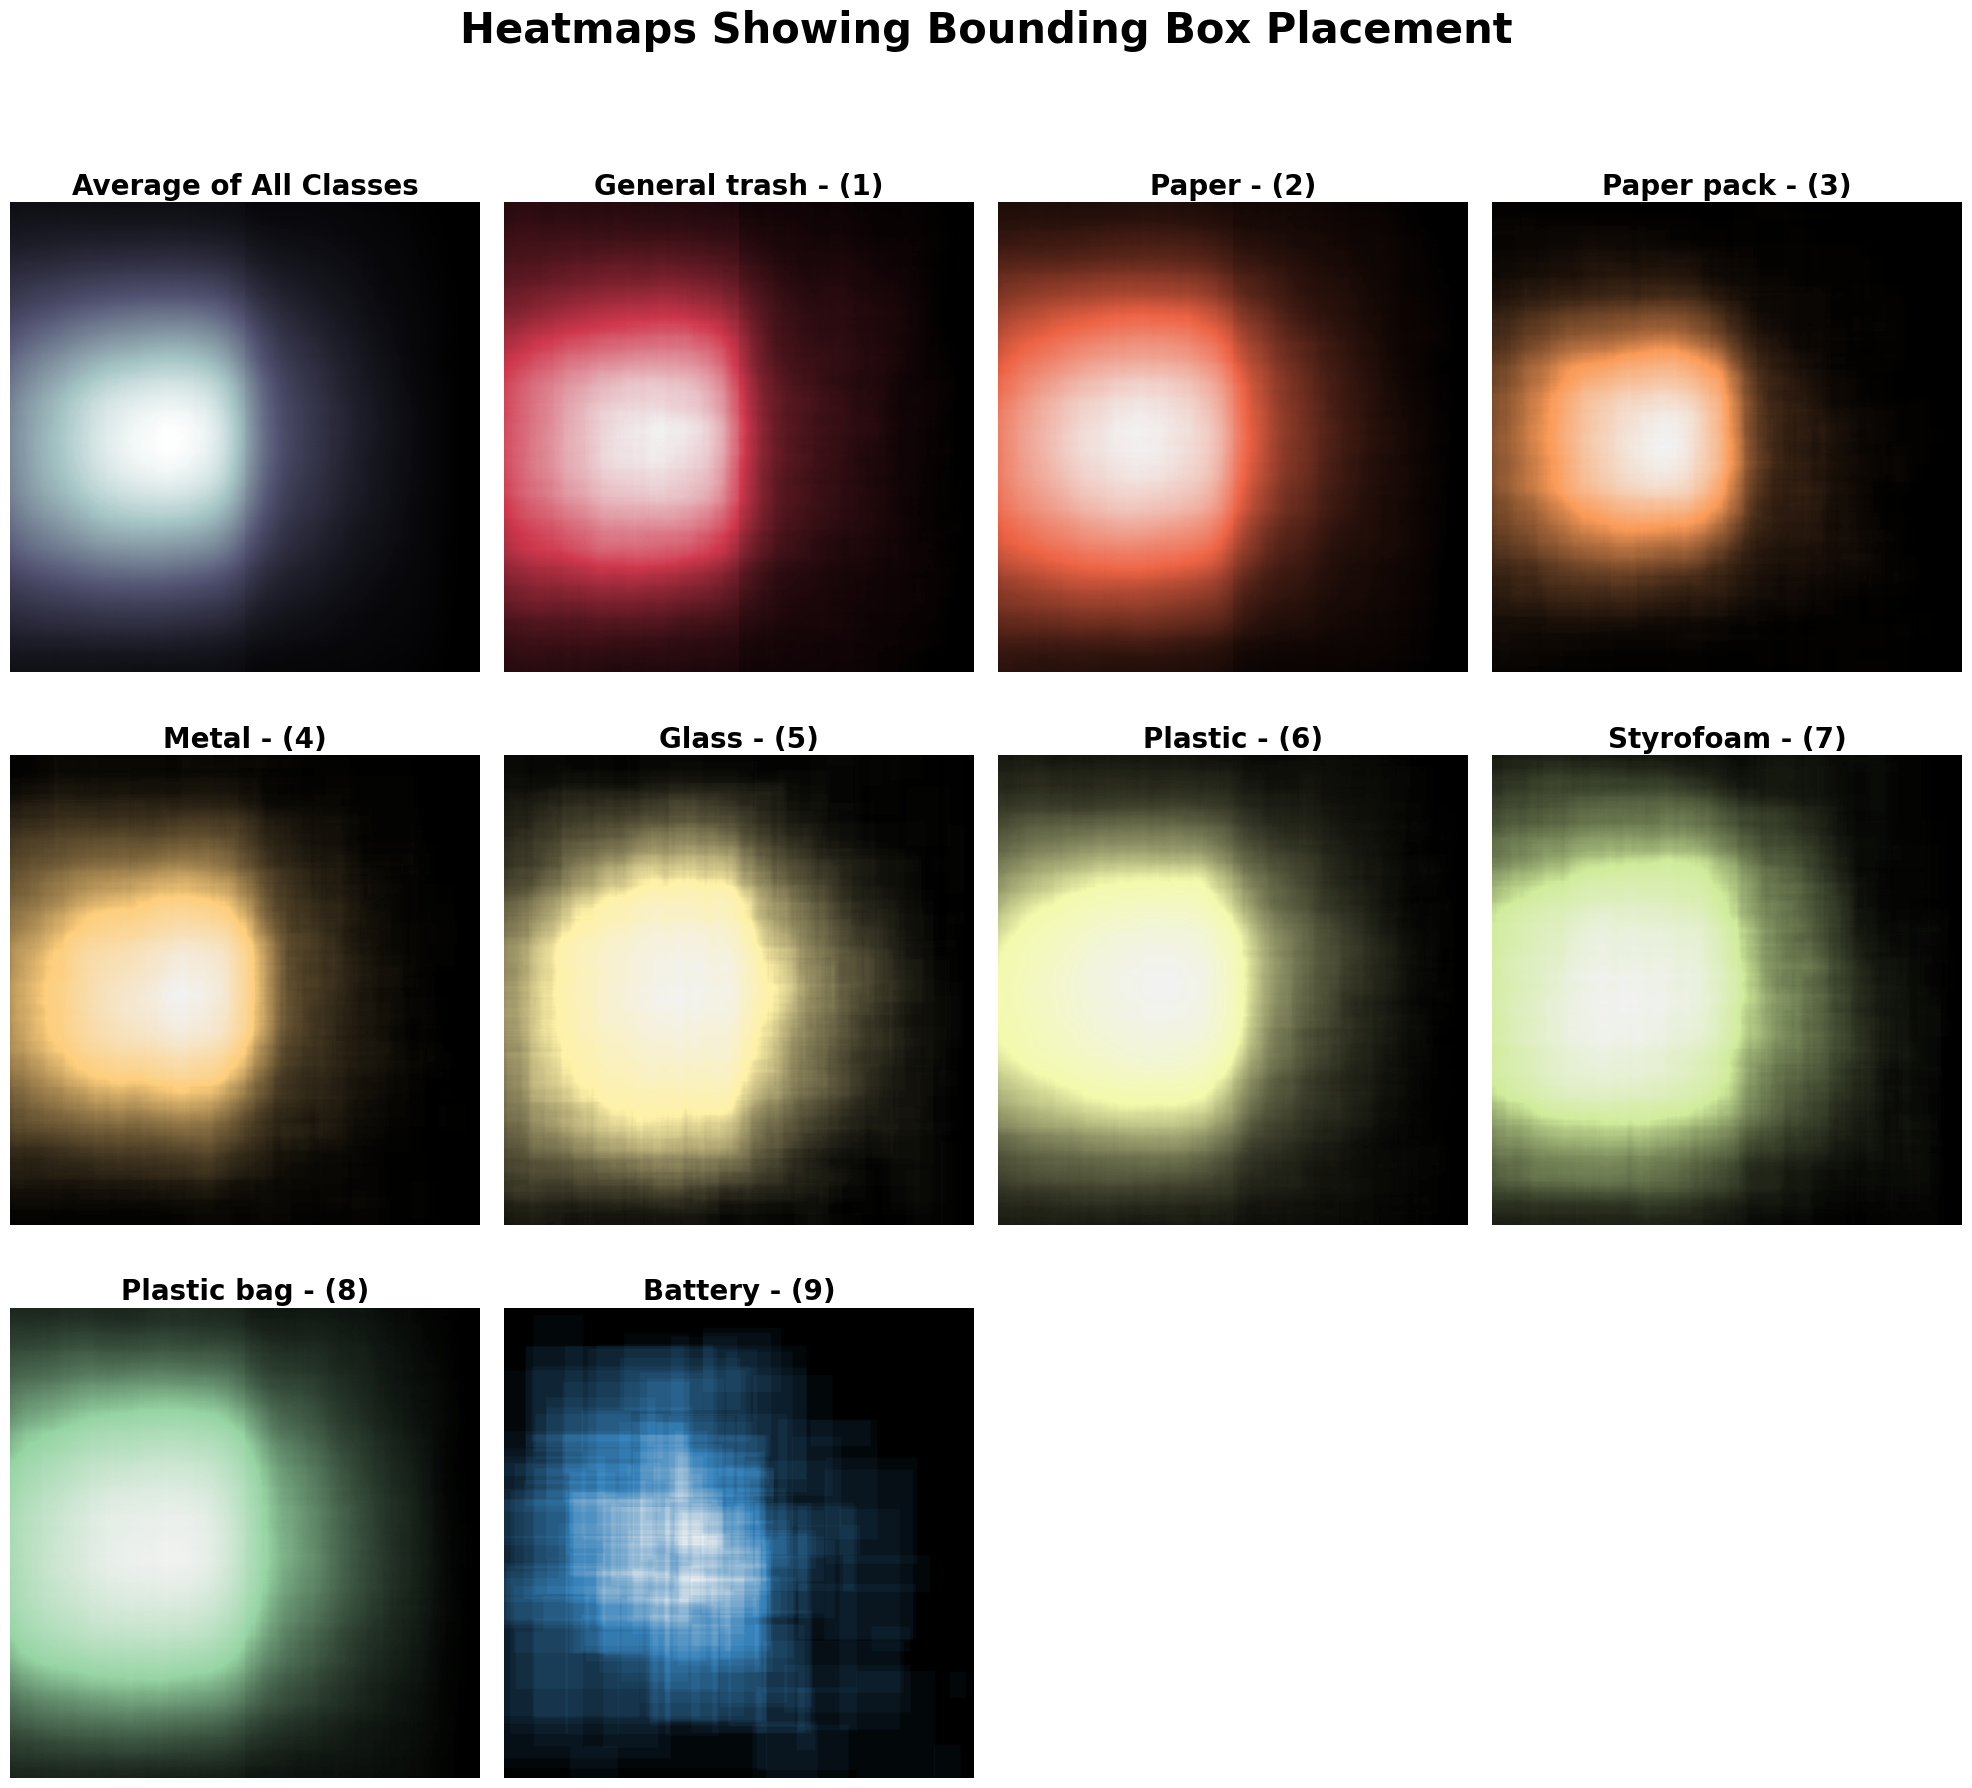

In [8]:
matplotlib.rcParams.update({'font.size': 16})
bbox_df = pd.DataFrame()
bbox_df['class_id'] = train_df['class_id'].values
bbox_df['class_name'] = train_df['class_name'].values
bbox_df['x_min'] = train_df['x_min'].values
bbox_df['x_max'] = train_df['x_max'].values
bbox_df['y_min'] = train_df['y_min'].values
bbox_df['y_max'] = train_df['y_max'].values
bbox_df['frac_x_min'] = train_df['x_min'].values / 1024
bbox_df['frac_x_max'] = train_df['x_max'].values / 1024
bbox_df['frac_y_min'] = train_df['y_min'].values / 1024
bbox_df['frac_y_max'] = train_df['y_max'].values / 1024
ave_src_img_height = 1024
ave_src_img_width = 1024

# DEFAULT

HEATMAP_SIZE = (ave_src_img_height, ave_src_img_width, 14)

# Initialize

heatmap = np.zeros((HEATMAP_SIZE), dtype=np.int16)
bbox_np = bbox_df[["class_id", "frac_x_min", "frac_x_max", "frac_y_min", "frac_y_max"]].to_numpy()
bbox_np[:, 1:3] *= ave_src_img_width
bbox_np[:, 3:5] *= ave_src_img_height
bbox_np = np.floor(bbox_np).astype(np.int16)

# Color map stuff

# 수정 부분 시작
x_coords = bbox_np[:, 1:3].reshape(-1)
half_widths = np.full(x_coords.shape[0], ave_src_img_width / 2)
mean_x = np.mean(x_coords)

if mean_x < ave_src_img_width / 2:
    bbox_np[:, 1] = np.maximum(bbox_np[:, 1], 0)
else:
    half_widths = (bbox_np[:, 2] - bbox_np[:, 1]) / 2
    half_widths = np.tile(half_widths[:, np.newaxis], (1, 2))
    bbox_np[:, 1:3] = (bbox_np[:, 1:3] - half_widths).astype(np.int16)
    bbox_np[:, 1] = np.maximum(bbox_np[:, 1], 0)
# 수정 부분 끝


for row in tqdm(bbox_np, total=bbox_np.shape[0]): 
    heatmap[row[3]:row[4]+1, row[1]:row[2]+1, row[0]] += 1

fig = plt.figure(figsize=(20,25))
plt.suptitle("Heatmaps Showing Bounding Box Placement\n ", fontweight="bold", fontsize=30)

for i in range(10):
    plt.subplot(4, 4, i+1)
    if i==0:
        plt.imshow(heatmap.mean(axis=-1), cmap="bone")
        plt.title(f"Average of All Classes", fontweight="bold", fontsize=20)
        
    else:
        plt.imshow(heatmap[:, :, i-1], cmap=custom_cmaps[i-1])
        plt.title(f"{classes[i-1]} - ({i})", fontweight="bold", fontsize=20)

    plt.axis(False)

fig.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

Distribution of bbox area

각 Class 별 bounding box의 크기 분포입니다.

In [9]:
# Update bbox dataframe to make this easier

bbox_df["frac_bbox_area"] = (bbox_df["frac_x_max"]-bbox_df["frac_x_min"])*(bbox_df["frac_y_max"]-bbox_df["frac_y_min"])

# bboxdf["classidasstr"] = bboxdf["classid"].map(classes)

display(bbox_df.head())

fig = px.box(bbox_df.sort_values(by="class_name"), x="class_name", y="frac_bbox_area", color="class_name",
             color_discrete_sequence=LABEL_COLORS_WOUT_NO_FINDING, notched=True,
             labels={"class_name":"Class Name", "frac_bbox_area":"BBox Area (%)"},
             title="<b>DISTRIBUTION OF BBOX AREAS AS % OF SOURCE IMAGE AREA  "
             "<i><sub>(Some Upper Outliers Excluded For Better Visualization)</sub></i></b>")

fig.update_layout(showlegend=True,
                  yaxis_range=[0, 1.1],
                  legend_title_text=None,
                  xaxis_title="",
                  yaxis_title="<b>Bounding Box Area %</b>",
                  width=1050,
                  yaxis=dict(
                      tickmode='linear',
                      tick0=0,
                      dtick=0.2,)
)

fig.show()

class_id     class_name  x_min  x_max  y_min  y_max  frac_x_min  \
0         0  General trash  197.6  745.4  193.7  663.4    0.192969   
1         3          Metal    0.0   57.6  407.4  588.0    0.000000   
2         7    Plastic bag    0.0  144.6  455.6  637.2    0.000000   
3         4          Glass  722.3  996.6  313.4  565.3    0.705371   
4         5        Plastic  353.2  586.9  671.0  774.4    0.344922   

   frac_x_max  frac_y_min  frac_y_max  frac_bbox_area  
0    0.727930    0.189160    0.647852        0.245382  
1    0.056250    0.397852    0.574219        0.009921  
2    0.141211    0.444922    0.622266        0.025043  
3    0.973242    0.306055    0.552051        0.065895  
4    0.573145    0.655273    0.756250        0.023045

박스 크기에 대한 분포

In [26]:
# 히스토그램과 KDE 플롯을 결합하여 생성

# 히스토그램 빈(bin)의 수
num_bins=10

fig = px.histogram(
    bbox_df, 
    x="frac_bbox_area", 
    marginal="box", 
    nbins=num_bins,  
    labels={"frac_bbox_area": "Bounding Box Area (%)"}
)

fig.update_layout(
    title="<b>DISTRIBUTION OF BBOX AREAS AS % OF SOURCE IMAGE AREA</b>",
    xaxis_title="<b>Bounding Box Area %</b>",
    yaxis_title="Count",
    width=1050
)

fig.show()


In [27]:
bins = pd.interval_range(start=0, end=1, freq=1/num_bins)

bbox_df['bin'] = pd.cut(bbox_df['frac_bbox_area'], bins)
bin_counts = bbox_df['bin'].value_counts()
total_count = len(bbox_df)
bin_percentages = (bin_counts / total_count).sort_index()
bin_percentages_rounded = (bin_percentages * 100).round(2)
bin_ranges_rounded = ["{:.3f} - {:.3f}".format(interval.left, interval.right) for interval in bin_percentages_rounded.index]

bin_table = pd.DataFrame({
    'Bin Range': bin_ranges_rounded,
    'Percentage': bin_percentages_rounded.values
})

bin_table

Bin Range  Percentage
0  0.000 - 0.100       71.95
1  0.100 - 0.200       14.81
2  0.200 - 0.300        6.55
3  0.300 - 0.400        3.12
4  0.400 - 0.500        1.56
5  0.500 - 0.600        0.86
6  0.600 - 0.700        0.48
7  0.700 - 0.800        0.22
8  0.800 - 0.900        0.15
9  0.900 - 1.000        0.30

In [28]:
import plotly.express as px

fig = px.histogram(
    bbox_df, 
    x="frac_bbox_area", 
    color="class_name",  
    marginal="box",  
    facet_col="class_name",  
    facet_col_wrap=3,  
    nbins=num_bins,
    labels={"frac_bbox_area": "Bounding Box Area (%)", "class_name": "Class"}
)

fig.update_layout(
    title="<b>DISTRIBUTION OF BBOX AREAS AS % OF SOURCE IMAGE AREA BY CLASS</b>",
    xaxis_title="<b>Bounding Box Area %</b>",
    yaxis_title="Count",
    width=2000
)

fig.show()


COCO AP_s, AP_m, AP_l 기준으로 현재 데이터 체크

In [23]:
import plotly.express as px

total_area = 1024 * 1024

# 각 bounding box의 면적 비율 계산
bbox_df['bbox_area_ratio'] = bbox_df['frac_bbox_area'] * total_area / total_area * 100  

# 면적 비율에 따라 'small', 'medium'으로 분류
bbox_df['size_category'] = pd.cut(bbox_df['bbox_area_ratio'], bins=[0, 0.33, 3, max(bbox_df['bbox_area_ratio'])],
                                  labels=['small', 'medium', 'large'])

fig = px.histogram(
    bbox_df, 
    x='bbox_area_ratio', 
    color='size_category',  
    labels={'bbox_area_ratio': 'BBox Area Ratio (%)', 'size_category': 'Size Category'}
)

fig.update_layout(
    title="<b>DISTRIBUTION OF BBOX AREAS AS % OF SOURCE IMAGE AREA BY SIZE CATEGORY</b>",
    xaxis_title="<b>Bounding Box Area Ratio %</b>",
    yaxis_title="Count",
    width=1050
)

fig.show()

c:\Users\bjong\anaconda3\envs\231113_torch\lib\site-packages\plotly\express\_core.py:2044: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [25]:
# 각 카테고리 별 개수 및 퍼센트를 계산하고 표로 만드는 코드

category_counts = bbox_df['size_category'].value_counts()

total_count = len(bbox_df)

category_percentages = (category_counts / total_count * 100).round(2)

category_table = pd.DataFrame({
    'Category': category_counts.index,
    'Count': category_counts.values,
    'Percentage (%)': category_percentages.values
})

category_table

Category  Count  Percentage (%)
0    large  12552           54.23
1   medium   8041           34.74
2    small   2551           11.02

Aspect Ratio for bounding boxes by class

각 Class 별 bounding box의 aspect ratio 값입니다. 이를 활용하여 anchor generator의 aspect ratio 비율을 조절해볼 수 있습니다.

In [7]:
# Aspect Ratio is Calculated as Width/Height

bbox_df["aspect_ratio"] = (bbox_df["x_max"]-bbox_df["x_min"])/(bbox_df["y_max"]-bbox_df["y_min"])

# Display average means for each class_id so we can examine the newly created Aspect Ratio Column

display(bbox_df.groupby("class_name").mean())

# Generate the bar plot

fig = px.bar(x=sorted(classes), y=bbox_df.groupby("class_name").mean()["aspect_ratio"],
             color=sorted(classes), opacity=0.85,
             color_discrete_sequence=LABEL_COLORS_WOUT_NO_FINDING,
             labels={"x":"Class Name", "y":"Aspect Ratio (W/H)"},
             title="<b>Aspect Ratios For Bounding Boxes By Class</b>",)

fig.update_layout(
    yaxis_title="<b>Aspect Ratio (W/H)</b>",
    xaxis_title=None,
    legend_title_text=None)

fig.add_hline(y=1, line_width=2, line_dash="dot",
             annotation_font_size=13,
             annotation_text="<b>SQUARE ASPECT RATIO</b>",
             annotation_position="bottom left",
             annotation_font_color="black")

fig.add_hrect(y0=0, y1=0.5, line_width=0, fillcolor="red", opacity=0.125,
             annotation_text="<b>>2:1 VERTICAL RECTANGLE REGION</b>",
             annotation_position="bottom right",
             annotation_font_size=13,
             annotation_font_color="red")

fig.add_hrect(y0=2, y1=3.5, line_width=0, fillcolor="green", opacity=0.04,
             annotation_text="<b>>2:1 HORIZONTAL RECTANGLE REGION</b>",
             annotation_position="top right",
             annotation_font_size=13,
             annotation_font_color="green")

fig.show()

class_id       x_min       x_max       y_min       y_max  \
class_name                                                                
Battery             8.0  411.002516  639.876730  432.148428  647.143396   
Clothing            9.0  335.697222  730.380128  346.516026  738.193590   
General trash       0.0  392.753707  618.990923  404.283737  619.753833   
Glass               4.0  410.682383  616.770265  398.284827  670.155703   
Metal               3.0  396.325962  647.355235  377.684722  634.891774   
Paper               1.0  384.916137  648.767191  384.417774  621.110941   
Paper pack          2.0  387.955741  632.852062  417.834671  637.919175   
Plastic             5.0  400.650357  640.025382  395.486035  626.166667   
Plastic bag         7.0  377.764175  653.141213  349.603109  650.812688   
Styrofoam           6.0  360.715439  659.862549  377.397150  629.704276   

               frac_x_min  frac_x_max  frac_y_min  frac_y_max  aspect_ratio  
class_name                                                                   
Battery          0.401370    0.624880    0.422020    0.631976      1.428327  
Clothing         0.327829    0.713262    0.338395    0.720892      1.228279  
General trash    0.383549    0.604483    0.394808    0.605228      1.433186  
Glass            0.401057    0.602315    0.388950    0.654449      1.043987  
Metal            0.387037    0.632183    0.368833    0.620011      1.239462  
Paper            0.375895    0.633562    0.375408    0.606554      1.391648  
Paper pack       0.378863    0.618020    0.408042    0.622968      1.296333  
Plastic          0.391260    0.625025    0.386217    0.611491      1.288092  
Plastic bag      0.368910    0.637833    0.341409    0.635559      1.106761  
Styrofoam        0.352261    0.644397    0.368552    0.614946      1.474087